In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from geopy.geocoders import Nominatim
from pandas_ods_reader import read_ods
import math
from pyroutelib3 import Router

router = Router("car") 

#Set parameters to geolocate
geolocator = Nominatim(user_agent="useer_agent", domain='nominatim.openstreetmap.org')
geocode = partial(geolocator.geocode, language="it", country_codes = "ita")

#Reachable cities
dft = pd.read_csv("../Dati/distanze/times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
cities = dft.columns
dfc=pd.read_csv("../Dati/altro/CitiesLocation.csv", delimiter=';')

lat = dfc["Lat"]
lon = dfc["Lon"]
cities = dfc["City"]

lonmin = round(lon.min()*100)/100
lonmax = math.ceil(lon.max()*10)/10
latmin = (round(lat.min() * 10)-1)/10
latmax = math.ceil(lat.max()*100)/100

In [62]:
def getLocation(name):
    geolocator = Nominatim(user_agent="useer_agent")
    geocode = partial(geolocator.geocode, language="it")
    location =geolocator.geocode(name)
    return location.latitude, location.longitude

def getCoords(string, z):
    return pd.Series(z).str.contains(string, case=False).values

def crop(cities_list):
    
    y_positions = [dfc.Lat[getCoords(paese, dfc.City)].values[0] for paese in cities_list.dropna()]
    x_positions = [dfc.Lon[getCoords(paese, dfc.City)].values[0] for paese in cities_list.dropna()]
    
    ruh_m = plt.imread('../Dati/altro/output.png')
    map_sizey, map_sizex, _ = ruh_m.shape
    nlonmin = round(min(x_positions)*100)/100
    nlonmax = math.ceil(max(x_positions)*10)/10
    nlatmin = (round(min(y_positions) * 10)-1)/10
    nlatmax = math.ceil(max(y_positions)*100)/100
    xmin = int(round((map_sizex*(nlonmin-lonmin))/(lonmax-lonmin)))
    xmax = int(round((map_sizex*(nlonmax-lonmin))/(lonmax-lonmin)))
    ymin = int(round(map_sizey*((nlatmin-latmin) / (latmax-latmin))))
    ymax = int(round(map_sizey*((nlatmax-latmin) / (latmax-latmin))))
    return ruh_m[max(0,map_sizey-ymax):max(0,map_sizey-ymin), max(0,xmin):max(0,xmax)], nlonmin, nlonmax, nlatmin, nlatmax, x_positions, y_positions

def get_row(df, string):
    return pd.Series(df.index).str.contains(string, case=False)

def getName(nome):
    city = dft[get_row(dft, nome).values].index[0]
    return city.split(",")[0].strip()

def getTrack(city_s, city_e):
    #Return list of track coordinates
    lati = dfc.Lat[getCoords(city_s, dfc.City)].values[0]
    long = dfc.Lon[getCoords(city_s, dfc.City)].values[0]
    start = router.findNode(lati, long)

    lati = dfc.Lat[getCoords(city_e, dfc.City)].values[0]
    long = dfc.Lon[getCoords(city_e, dfc.City)].values[0]
    end = router.findNode(lati, long)

    status, route = router.doRoute(start, end) # Find the route - a list of OSM nodes
    
    lat_list=[]
    lon_list=[]

    if status == 'success':
        routeLatLons = list(map(router.nodeLatLon, route)) # Get actual route coordinates
        for el in routeLatLons:
            lat_list.append(el[0])
            lon_list.append(el[1])
    return lat_list, lon_list

In [59]:
(min(lat), max(lat), min(lon), max(lon))

(44.9286315, 45.470343299999996, 9.493822300000001, 10.520690400000001)

In [60]:
(lonmin, latmin, lonmax, latmax)

(9.49, 44.8, 10.6, 45.48)

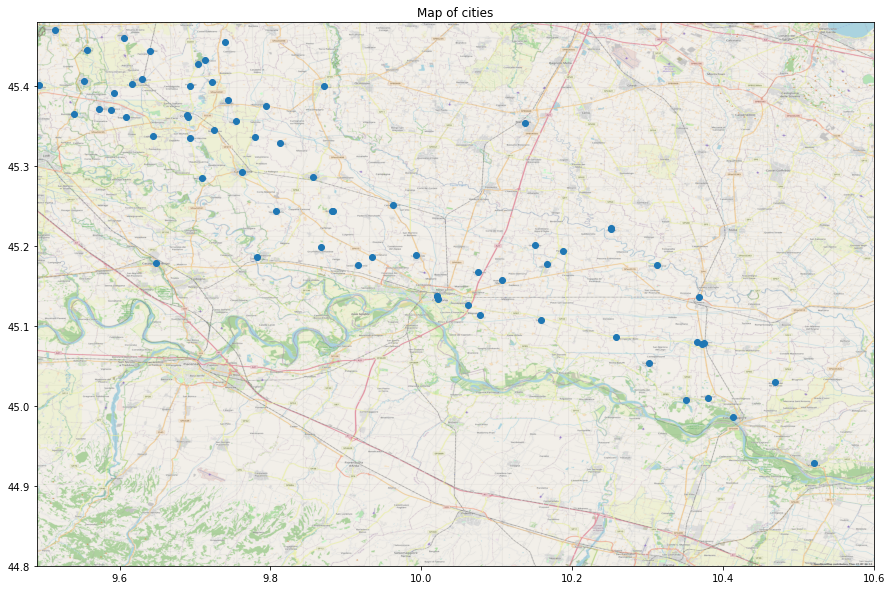

In [29]:
BBox = (lonmin, lonmax,
        latmin, latmax)
ruh_m = plt.imread('../Dati/altro/output.png')

fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(dfc.Lon, dfc.Lat, zorder=1, alpha=1, marker="o")
ax.set_title('Map of cities')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
k=0
for i, txt in enumerate(cities.unique()[:len(cities)-1]):
    try:
        k+=1
        txt.index(",")
        ax.annotate(txt[:txt.index(',')], (coords[i][1], coords[i][0]), zorder=2, color="red")
    except:
        k+=1
        
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'auto')
plt.show()

In [68]:
def printTrack(day, csv, f, title, plot_index):
    ruh_m, nlonmin, nlonmax, nlatmin, nlatmax, x_positions, y_positions = crop(csv[day])

    BBox = (nlonmin, nlonmax,
            nlatmin, nlatmax)
    ax = f.add_subplot(1, 2, plot_index)

    ax.scatter(x_positions, y_positions, zorder=1, alpha=1, marker="o")

    ax.set_title(title)
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    for i, txt in enumerate(csv[day][:len(csv[day].dropna())]):
        try:
            ax.annotate(getName(txt), (x_positions[i], y_positions[i]), zorder=2, aplha=0.5, color='red', fontweight="bold")
        except:
            ax.annotate(getName(txt), (x_positions[i], y_positions[i]), zorder=2, color='red', fontweight="bold")
        if(i>0):
            la, lo = getTrack(prec, txt)
            ax.plot(lo, la, zorder=1, alpha=1, color="black")
        prec = txt

    ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'auto')  

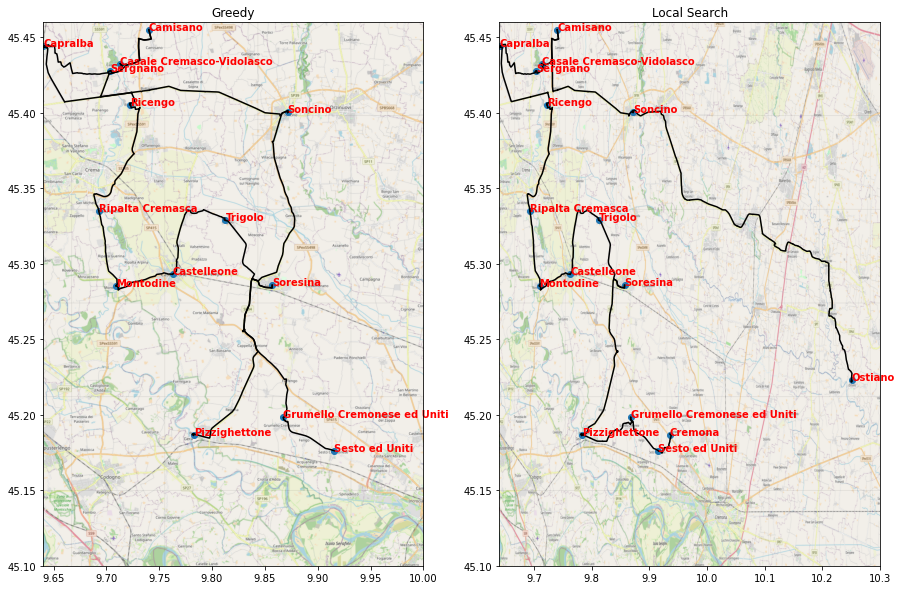

In [69]:
day="lunedi"
f1 = pd.read_csv("../Dati/turni_f/furgoncino1_routing.csv", sep=";")
f = plt.figure(figsize=(15,10))
printTrack(day, f1, f, "Greedy", 1)

f1 = pd.read_csv("../Dati/turni_f/ls1_shifts.csv", sep=";")
printTrack(day, f1, f, "Local Search", 2)

plt.show()


In [31]:
f1[day]

0                         cremona, sesto 39
1                        crema, civerchi, 9
2              capergnanica, xi febbraio, 7
3                 bagnolo cremasco, roma, 3
4      vaiano cremasco,  gloriosi caduti, 3
5                  monte cremasco, roma, 12
6                         dovera, oldrini 2
7                     pandino, castello, 15
8                     agnadello, marconi, 6
9          rivolta d'adda, stefano renzi, 5
10       spino d'adda, circonvallazione, 13
11    trescore cremasco, vittorio veneto, 1
12            casaletto vaprio, maggiore, 7
13                      ostiano, mazzini, 1
14                                      NaN
15                                      NaN
Name: venerdi, dtype: object